In [1]:
import pandas
import numpy as np
import bgshr
import os, pickle
from scipy.stats import gamma
from scipy import interpolate, optimize

In [2]:
import matplotlib, matplotlib.pylab as plt

plt.rcParams["legend.title_fontsize"] = "xx-small"
matplotlib.rc("xtick", labelsize=7)
matplotlib.rc("ytick", labelsize=7)
matplotlib.rc("axes", labelsize=8)
matplotlib.rc("axes", titlesize=8)
matplotlib.rc("legend", fontsize=6)
plt.rcParams['legend.title_fontsize'] = 'xx-small'

In [35]:
import demes, demesdraw

Combine lookup tables from moments and classic BGS scenarios.

In [54]:
df = bgshr.Util.load_lookup_table("../lookup_tables/lookup_tbl_4_epochs.csv.gz")

sstrong = -np.logspace(0, -3, 34)[:-1]
rs = np.sort(list(set(df["r"])))
gens = np.sort(list(set(df["Generation"])))

Ns = [15000, 40000, 20000, 30000]
Ts = [0, 4000, 24000, 100000]

df_strong = bgshr.ClassicBGS.build_lookup_table_n_epoch(
    sstrong, rs, Ns, Ts, 
    generations=gens, 
    uL=1e-8, uR=1e-8)
df_new = pandas.concat((df_strong, df), ignore_index=True)

In [4]:
_oob_val = 1e20

def obj_func_fixed_mu(params, data=None, verbose=False,
             lower_bound=None, upper_bound=None,
             Bvals_Ne=None, scaling=1):
    if lower_bound is None:
        lower_bound = [0 for _ in params]
    if upper_bound is None:
        upper_bound = [np.inf for _ in params]
    for p, l, u in zip(params, lower_bound, upper_bound):
        if p <= l or p >= u:
            return _oob_val
    assert len(params) == 2
    shape, scale = params
    weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scaling * scale)
    pred = bgshr.Util.integrate_with_weights(Bvals_Ne, weights[:-1], u_fac=scaling)
    ret = np.sum((pred - data) ** 2)
    if verbose:
        print(f"{func_calls}\t{params}\t{ret}")
    return ret

def obj_func_fixed_dfe(params, data=None, verbose=False,
             lower_bound=None, upper_bound=None,
             Bvals_Ne=None, scaling=1,
             shape=None, scale=None):
    if lower_bound is None:
        lower_bound = [0 for _ in params]
    if upper_bound is None:
        upper_bound = [np.inf for _ in params]
    for p, l, u in zip(params, lower_bound, upper_bound):
        if p <= l or p >= u:
            return _oob_val
    assert len(params) == 1
    u_fac = params[0]
    weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scaling * scale)
    pred = bgshr.Util.integrate_with_weights(Bvals_Ne, weights[:-1], u_fac=scaling * u_fac)
    ret = np.sum((pred - data) ** 2)
    if verbose:
        print(f"{func_calls}\t{params}\t{ret}")
    return ret

In [5]:
r = 1e-8
L = 10_000_000

def draw_elements(width=1000, n_elements=20):
    elements = []
    for _ in range(n_elements):
        center = width / 2 + np.random.rand() * (L - width)
        element = [np.max([0, int(center - width / 2)]), np.min([L, int(center + width / 2)])]
        elements.append(element)
    elements = bgshr.Util.break_up_elements(elements)
    return elements

rmap = bgshr.Util.build_uniform_rmap(r, L)

In [192]:
shape = 0.2
scales = [0.001, 0.03, 0.5]
xs = np.linspace(0, L, L // 5000 + 1)

for scale in scales:
    print("mean, variance:", shape * scale, shape * scale ** 2)
    print("ss:", [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1])
    print("cdf:", gamma.cdf([0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], shape, scale=scale))
    print()

mean, variance: 0.0002 2e-07
ss: [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
cdf: [0.         0.43286756 0.6760432  0.94761957 0.99999854 1.
 1.        ]

mean, variance: 0.006 0.00018
ss: [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
cdf: [0.         0.21959837 0.34786611 0.54859982 0.82981262 0.997523
 1.        ]

mean, variance: 0.1 0.05
ss: [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
cdf: [0.         0.12510713 0.19827548 0.31415125 0.49641091 0.7644346
 0.98701341]



In [193]:
elements = draw_elements()
fname = f"fit_dfe.shape_{shape}.scales_" + "_".join([str(sc) for sc in scales]) + "_4_epochs.pkl"
print(fname)
try:
    outputs = pickle.load(open(fname, "rb"))
except IOError:
    outputs = {}
    
    df_sub = df_new[df_new["Generation"] == 100000]
    _, _, splines0 = bgshr.Util.generate_cubic_splines(df_sub)
    
    for scale in scales:
        print("mean, variance:", shape * scale, shape * scale ** 2)
        print("ss:", [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1])
        print("cdf:", gamma.cdf([0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], shape, scale=scale))
        k = (shape, scale)
        outputs[k] = {"fixed_mu": [], "fixed_dfe": []}
        
        for g in gens:
            df_sub = df_new[df_new["Generation"] == g]
            
            # get predicted B values at the given generation
            _, _, splines = bgshr.Util.generate_cubic_splines(df_sub)
            s_vals = np.sort(np.unique(df_sub["s"]))
            weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scale)
            Bvals = bgshr.Predict.Bvals(xs, s_vals[:-1], splines, rmap=rmap, elements=elements)
            B = bgshr.Util.integrate_with_weights(Bvals, weights[:-1])
    
            # get Ne based on expected diversity at that time
            pi0 = bgshr.ClassicBGS.expected_tmrca_n_epoch_neutral([15000, 40000, 20000, 30000], [0, 100000 - g])
            Ne = pi0 / 2
            print(g, pi0, Ne)
    
            # rescale by that Ne, and build the equivalent steady-state B map
            scaling = Ne / 3e4 
            rmap_Ne = bgshr.Util.build_uniform_rmap(r * scaling, L)
            Bvals_Ne = bgshr.Predict.Bvals(xs, s_vals[:-1], splines0, rmap=rmap_Ne, elements=elements)
    
            # fit with fixed mutation rate
            p0 = [shape, scale]
            out = optimize.fmin(obj_func_fixed_mu, p0,
                                args=(B, False, None, None, Bvals_Ne, scaling),
                                disp=0)
            print("fixed mu:", out)
            outputs[k]["fixed_mu"].append(out)
    
            # fit with fixed DFE
            p0 = [1]
            out = optimize.fmin(obj_func_fixed_dfe, p0,
                                args=(B, False, None, None, Bvals_Ne, scaling, shape, scale),
                                disp=0)
            print("fixed dfe:", out)
            outputs[k]["fixed_dfe"].append(out)
        print()
    with open(fname, "wb+") as fout:
        pickle.dump(outputs, fout)

fit_dfe.shape_0.2.scales_0.001_0.03_0.5_4_epochs.pkl
mean, variance: 0.0002 2e-07
ss: [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
cdf: [0.         0.43286756 0.6760432  0.94761957 0.99999854 1.
 1.        ]
0.0 31070.219800417573 15535.109900208787
fixed mu: [3.65699164e-01 2.93199173e-04]
fixed dfe: [1.23369141]
500.0 31088.206267969308 15544.103133984654
fixed mu: [3.67181421e-01 2.88532136e-04]
fixed dfe: [1.23242188]
1000.0 31106.495022037197 15553.247511018599
fixed mu: [3.68786095e-01 2.84123101e-04]
fixed dfe: [1.23144531]
1500.0 31125.09114294831 15562.545571474155
fixed mu: [3.70379024e-01 2.79972627e-04]
fixed dfe: [1.23085938]
2000.0 31143.999796411354 15571.999898205677
fixed mu: [3.71941044e-01 2.76448545e-04]
fixed dfe: [1.23056641]
2500.0 31163.22623495166 15581.61311747583
fixed mu: [3.73464134e-01 2.73454002e-04]
fixed dfe: [1.23076172]
3000.0 31182.775799370225 15591.387899685113
fixed mu: [3.74832432e-01 2.71269470e-04]
fixed dfe: [1.23144531]
3500.0 31202.653920227312 1

In [195]:
with open(fname, "wb+") as fout:
    pickle.dump(outputs, fout)

Text(0, 0.5, 'Relative mut. rate')

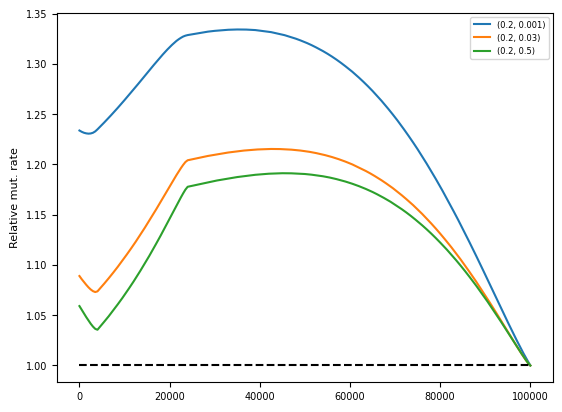

In [196]:
for k in outputs.keys():
    plt.plot(gens, outputs[k]["fixed_dfe"], label=str(k))
plt.plot(gens, np.ones(len(gens)), "k--")
plt.legend()
plt.ylabel("Relative mut. rate")

Text(0, 0.5, 'shape')

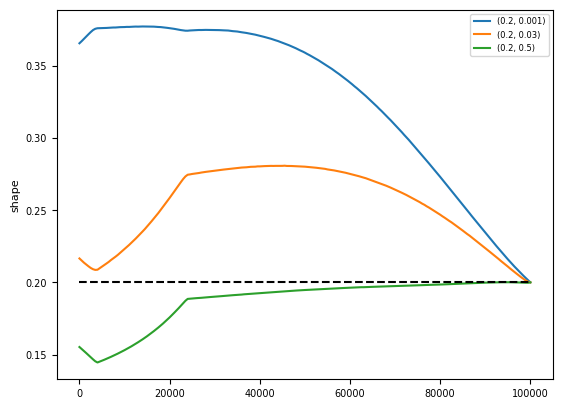

In [197]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0], label=str(k))
plt.plot(gens, np.ones(len(gens)) * shape, "k--")
#plt.yscale("log")
plt.legend()
plt.ylabel("shape")

Text(0, 0.5, 'scale')

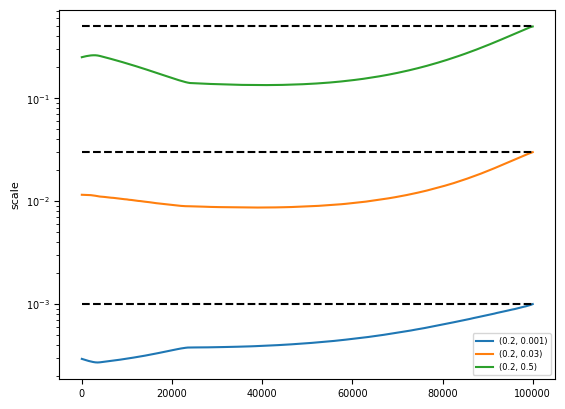

In [198]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 1], label=str(k))
for scale in scales:
    plt.plot(gens, np.ones(len(gens)) * scale, "k--")
plt.yscale("log")
plt.legend()
plt.ylabel("scale")

Text(0, 0.5, 'E[s]')

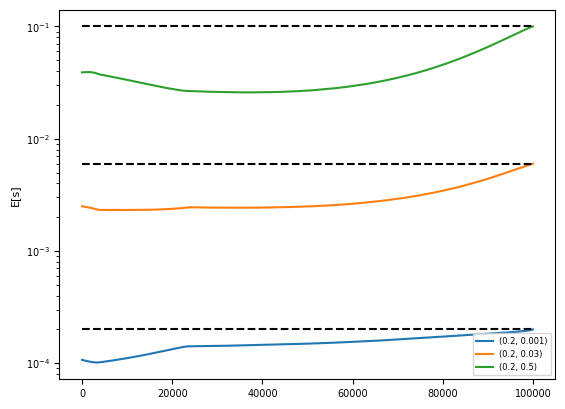

In [199]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1], label=str(k))
for scale in scales:
    plt.plot(gens, np.ones(len(gens)) * shape * scale, "k--")
plt.yscale("log")
plt.legend()
plt.ylabel("E[s]")

Text(0, 0.5, 'Var(s)')

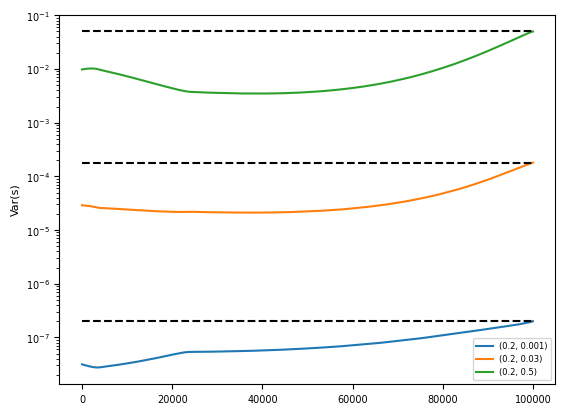

In [200]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1] ** 2, label=str(k))
for scale in scales:
    plt.plot(gens, np.ones(len(gens)) * shape * scale ** 2, "k--")
plt.yscale("log")
plt.legend()
plt.ylabel("Var(s)")

In [201]:
i = 0
fname = f"fit_dfe_shape_{shape}.scales_" + "_".join([str(sc) for sc in scales]) + "4_epochs.pkl"
while os.path.exists(fname):
    i += 1
    fname = f"fit_dfe.{i}.pkl"
pickle.dump(outputs, open(fname, "wb+"))

In [202]:
from bokeh.palettes import Greens
colors = {}
i = 2
labels = {}
for k in outputs.keys():
    colors[k] = Greens[4][i]
    i -= 1
    labels[k] = f"{k[0]}"

In [203]:
colors

{(0.2, 0.001): '#bae4b3', (0.2, 0.03): '#74c476', (0.2, 0.5): '#238b45'}

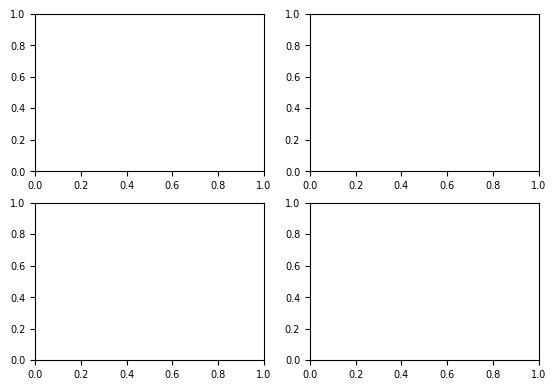

In [204]:
fig, axes = plt.subplots(2, 2, figsize=(6.5, 4.5));

In [205]:
b = demes.Builder()
b.add_deme(name="Pop", epochs=[dict(start_size=N, end_time=T) for N, T in zip(Ns[::-1], Ts[::-1])])
g = b.resolve()

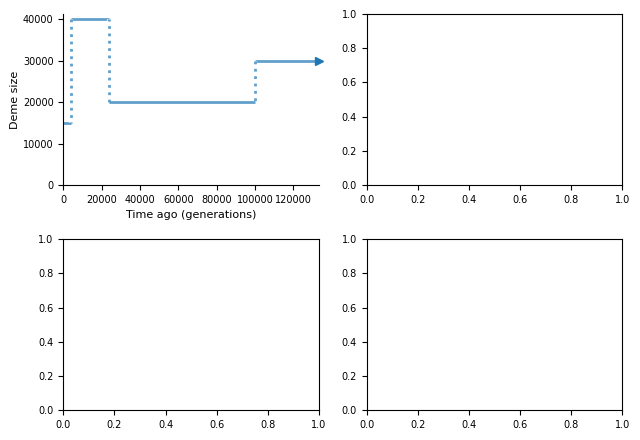

In [206]:
axes[0][0].clear()
demesdraw.size_history(g, log_time=False, log_size=False, ax=axes[0][0], inf_ratio=0.25)
axes[0][0].set_ylabel("Deme size", rotation=90, labelpad=2)
axes[0][0].set_xlabel("Time ago (generations)")
fig.tight_layout()
fig

In [216]:
axes[0][1].clear()
for k in outputs.keys():
    axes[0][1].plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0],
                 label=str(k), color=colors[k])
axes[0][1].axhline(y=shape, linestyle='--', lw=0.75, color='gray', zorder=0)
axes[0][1].set_xlabel("Generations since size change")
axes[0][1].set_ylabel("Shape")
axes[0][1].set_title(r"Fixed mutation rate")
axes[0][1].set_yscale("log")
axes[0][1].legend(handlelength=0.5, frameon=True, title=r"($\alpha$, $\beta$)", fontsize=6, loc="upper right")

In [217]:
axes[1][1].clear()
for k in outputs.keys():
    axes[1][1].plot(gens, np.array(outputs[k]["fixed_mu"])[:, 1],
                 label=labels[k], color=colors[k])
for scale in scales:
    axes[1][1].axhline(y=scale, linestyle='--', lw=0.75, color='gray', zorder=0)
axes[1][1].set_xlabel("Generations since size change")
axes[1][1].set_ylabel("Scale")
#axes[1][1].legend()
axes[1][1].set_yscale("log")
axes[1][1].set_title(r"Fixed mutation rate")

Text(0.5, 1.0, 'Fixed mutation rate')

In [218]:
axes[1][0].clear()
for k in outputs.keys():
    axes[1][0].plot(gens, np.array(outputs[k]["fixed_dfe"])[:, 0],
                 label=str(k), color=colors[k])
axes[1][0].axhline(y=1, linestyle='--', lw=1, color='gray', zorder=0)
axes[1][0].set_xlabel("Generations since size change")
axes[1][0].set_ylabel("Relative mutation rate")
axes[1][0].legend(handlelength=0.5, frameon=True, title=r"($\alpha$, $\beta$)", fontsize=6, loc="upper right")
axes[1][0].set_title(r"Fixed DFE")
#axes[1][0].set_ylim(top=1.4)

Text(0.5, 1.0, 'Fixed DFE')

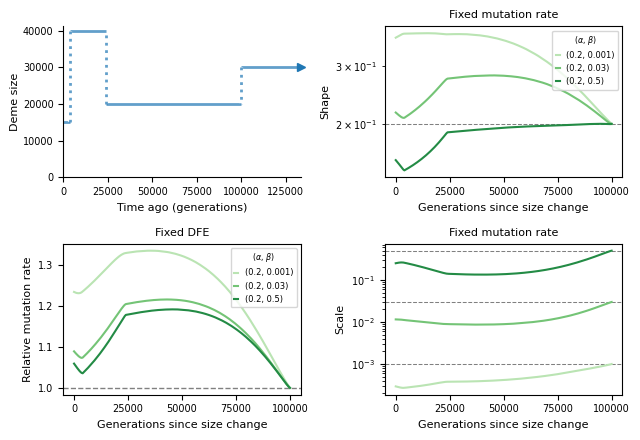

In [219]:
axes[0][0].set_xticks([0, 25000, 50000, 75000, 100000, 125000])
axes[0][1].set_xticks(axes[0][0].get_xticks()[:-1])
axes[1][0].set_xticks(axes[0][0].get_xticks()[:-1])
axes[1][1].set_xticks(axes[0][0].get_xticks()[:-1])
fig.tight_layout()
fig

In [220]:
fname = f"fit_dfe.shape_{shape}.scales_" + "_".join([str(sc) for sc in scales]) + "_4_epochs.pdf"
fig.savefig(fname)

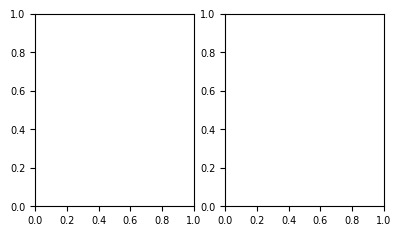

In [168]:
fig2, axes2 = plt.subplots(1, 2, figsize=(4.5, 2.5))

In [169]:
axes2[0].clear()
for k in outputs.keys():
    axes2[0].plot(gens,
                  np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1],
                  label=labels[k], color=colors[k])
for scale in scales:
    axes2[0].axhline(y=shape * scale, linestyle='--', lw=0.75, color='gray', zorder=0)
axes2[0].set_xlabel("Generations since size change")
axes2[0].set_ylabel("E[s]")
axes2[0].set_title(r"Fixed mutation rate")
axes2[0].set_yscale("log")

In [170]:
axes2[1].clear()
for k in outputs.keys():
    axes2[1].plot(gens,
                  np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1] ** 2,
                  label=str(k), color=colors[k])
for scale in scales:
    axes2[1].axhline(y=shape * scale ** 2, linestyle='--', lw=0.75, color='gray', zorder=0)
axes2[1].set_xlabel("Generations since size change")
axes2[1].set_ylabel("Var(s)")
axes2[1].set_title(r"Fixed mutation rate")
axes2[1].set_yscale("log")

In [171]:
fig2.tight_layout()
fname = f"fit_dfe.mean_var.shape_{shape}.scales_" + "_".join([str(sc) for sc in scales]) + "_4_epochs.pdf"
fig2.savefig(fname)

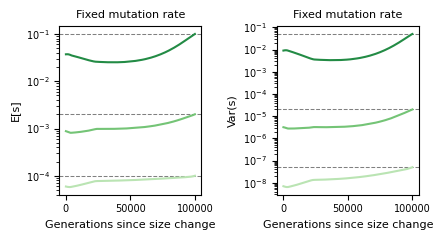

In [172]:
fig2